In [2]:
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table, Column

In [3]:
token=ac.login('mgkadrmas')

In [4]:
df=Table(fits.getdata('LMCParallax4.fits'))
df['Dist']=1/df['parallax']
df['Disterror']=df['sigma']/(df['parallax']**2)

In [5]:
chi2s=fits.getdata('4LMCParallaxChi2.fits')

In [6]:
def InclineDiskDist(ra, dec, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(81.9) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(-69.866667) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dist = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dist

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    
    
    
def roi_cut(xcut,ycut,x,y): 
    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)
    return ind, cutind
    print (ind, cutind)

In [7]:
xcut=[102.237903,99.022177,95.584677,90.372984,85.715726,75.625000,71.189516,67.752016,63.981855,62.207661,59.879032,58.770161,57.217742,56.219758,59.213710,63.870968,71.522177,78.840726,87.046371,93.256048,100.020161,103.014113,104.012097]
ycut=[-64.938814,-63.151940,-61.439520,-59.801552,-58.312490,-58.238037,-58.461396,-59.429286,-60.173817,-62.109597,-65.385533,-68.512562,-71.490685,-75.138886,-76.851306,-77.893650,-78.489274,-78.191462,-78.191462,-77.521384,-75.362245,-72.458575,-68.438109]
x=df['ra'].ravel()
y=df['dec'].ravel()
(ind, cutind) = roi_cut(xcut,ycut,x,y)


In [8]:
pos = np.argmin(chi2s['chi2val'].data)
thetavals=chi2s['theta'].ravel()
thetamod=thetavals[pos]
inclinvals=chi2s['inclin'].ravel()
inclinmod=inclinvals[pos]
print(thetamod,inclinmod)

332.0 72.0


In [9]:
pa= thetamod 
io= inclinmod
dtype = np.dtype([('ra',float),('dec',float),('dist',float)])
dcat = np.zeros([56,26], dtype=dtype)
for i in range (56):
    ra=i+55
    for j in range (26):
        dec=j-80
        (dist) = InclineDiskDist(ra,dec,pa,io)
        dcat[i,j]['ra']=ra
        dcat[i,j]['dec']=dec
        dcat[i,j]['dist']=dist

In [10]:
dsigma= df['sigma'].ravel()/((df['parallax'].ravel()**2))
dsigma=np.reshape(dsigma, (56,26))
synth = dcat.copy()
synth['dist'] = dcat['dist'] + np.random.randn(dcat.shape[0],dcat.shape[1])*dsigma

In [11]:
def chi2(Dist, Distheory, Dsigma):
    chii=((Dist - Distheory)**2)/((Dsigma)**2)
    chi2=np.sum(chii)
    return chi2

In [12]:
Distmod=synth['dist']
Dists=1/df['parallax']

In [12]:
chivals=[]
for i in range(100):
    dsigma= df['sigma'].ravel()/((df['parallax'].ravel()**2))
    dsigma=np.reshape(dsigma, (56,26))
    synth = dcat.copy()
    synth['dist'] = dcat['dist'] + np.random.randn(dcat.shape[0],dcat.shape[1])*dsigma
    Distmod=synth['dist']
    Dists=1/df['parallax']
    chival=chi2(Dists, Distmod)
    chivals.append(abs(chival))

TypeError: chi2() missing 1 required positional argument: 'Dsigma'

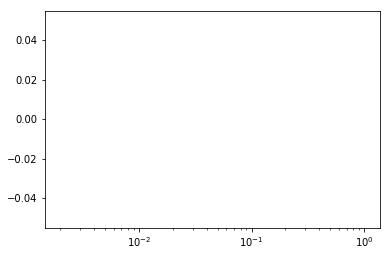

In [13]:
plt.hist(chivals, bins=500)
plt.xscale('log')

In [14]:
racenter=81.9
deccenter= -69.866667
distcenter=49

Dists=1/df['parallax']
dsigma= df['sigma']/((df['parallax']**2))
dsigma=np.reshape(dsigma, (56,26))

chitype = np.dtype([('theta',float),('inclin',float),('chi2val',float)])
chi2s = np.zeros([170,90], dtype=chitype)
for i in range (170):
    theta=i+191
    for j in range (90):
        inclin=j-17
        dtype=np.dtype([('ra',float),('dec',float),('distheory',float)])
        cat = np.zeros([56,26], dtype=dtype)
        for x in range (56):
            ra=x+55
            for y in range (26):
                dec=y-80
                (distheory) = InclineDiskDist(ra,dec,theta,inclin)
                cat[x,y]['ra']=ra
                cat[x,y]['dec']=dec
                cat[x,y]['distheory']=distheory
        synth = cat.copy()
        synth['distheory'] = cat['distheory'] + np.random.randn(dcat.shape[0],dcat.shape[1])*dsigma
        chi2val = chi2(Dists, synth['distheory'])
        chi2s[i,j]['theta']=theta
        chi2s[i,j]['inclin']=inclin
        chi2s[i,j]['chi2val']=chi2val

pos = np.argmin(chi2s['chi2val'].data)
thetavals=chi2s['theta'].ravel()
thetamod=thetavals[pos]
inclinvals=chi2s['inclin'].ravel()
inclinmod=inclinvals[pos]
print(thetamod,inclinmod)


TypeError: chi2() missing 1 required positional argument: 'Dsigma'

In [15]:
dtype=np.dtype([('thetamod',float),('inclinmod',float)])
MC = np.zeros(10, dtype=dtype)

racenter=81.9
deccenter= -69.866667
distcenter=49

Dists=1/df['parallax']
dsigma= df['sigma']/((df['parallax']**2))
dsigma=np.reshape(dsigma, (56,26))

for t in range(10):
    chitype = np.dtype([('theta',float),('inclin',float),('chi2val',float)])
    chi2s = np.zeros([170,90], dtype=chitype)
    for i in range (170):
        theta=i+191
        for j in range (90):
            inclin=j-17
            dtype=np.dtype([('ra',float),('dec',float),('distheory',float)])
            cat = np.zeros([56,26], dtype=dtype)
            for x in range (56):
                ra=x+55
                for y in range (26):
                    dec=y-80
                    (distheory) = InclineDiskDist(ra,dec,theta,inclin)
                    cat[x,y]['ra']=ra
                    cat[x,y]['dec']=dec
                    cat[x,y]['distheory']=distheory
            synth = cat.copy()
            synth['distheory'] = cat['distheory'] + np.random.randn(dcat.shape[0],dcat.shape[1])*dsigma
            chi2val = chi2(Dists, synth['distheory'])
            chi2s[i,j]['theta']=theta
            chi2s[i,j]['inclin']=inclin
            chi2s[i,j]['chi2val']=chi2val

    pos = np.argmin(chi2s['chi2val'].data)
    thetavals=chi2s['theta'].ravel()
    thetamod=thetavals[pos]
    inclinvals=chi2s['inclin'].ravel()
    inclinmod=inclinvals[pos]
    MC[t]['thetamod']=thetamod
    MC[t]['inclinmod']=inclinmod
    
MC = Table(MC)
MC.write('LMCPlxMC1.fits', format='fits')

TypeError: chi2() missing 1 required positional argument: 'Dsigma'

In [13]:
def findbestdiskmodel(cat): 
    chitype = np.dtype([('theta',float),('inclin',float),('chi2val',float)])
    chi2s = np.zeros([170,90], dtype=chitype)
    for i in range (170):
        theta=i+191
        for j in range (90):
            inclin=j-17
            model = creatediskmodel(theta, inclin)
            chi2val = chi2(cat['Dist'], model['distheory'], cat['Disterror'])
            chi2s[i,j]['theta']=theta
            chi2s[i,j]['inclin']=inclin
            chi2s[i,j]['chi2val']=chi2val
    pos = np.argmin(chi2s['chi2val'].data)
    thetavals=chi2s['theta'].ravel()
    thetamod=thetavals[pos]
    inclinvals=chi2s['inclin'].ravel()
    inclinmod=inclinvals[pos]
    return (thetamod, inclinmod)


In [14]:
def creatediskmodel(theta, inclin):
    dtype=np.dtype([('ra',float),('dec',float),('distheory',float)])
    cat = np.zeros([56,26], dtype=dtype)
    for x in range (56):
        ra=x+55
        for y in range (26):
            dec=y-80
            (distheory) = InclineDiskDist(ra,dec,theta,inclin)
            cat[x,y]['ra']=ra
            cat[x,y]['dec']=dec
            cat[x,y]['distheory']=distheory
    return cat

In [ ]:
dtype=np.dtype([('theta',float),('inclin',float)])
MC = np.zeros(100, dtype=dtype)

model = creatediskmodel(332, 72)

for t in range(100):
    synth = df.copy()
    synth['Dist'] = model['distheory'] + np.random.randn(dcat.shape[0],dcat.shape[1])*df['Disterror']
    synth['Disterror'] = df['Disterror']
    theta, inclin = findbestdiskmodel(synth)
    MC[t]['theta'] = theta
    MC[t]['inclin'] = inclin

MC = Table(MC)
MC.write('LMCPlxMCbig1.fits', format='fits')
###Find Standard deviation of inclin and theta values np.std


In [15]:
MC=fits.getdata('LMCPlxMCbig1.fits')

In [17]:
MC['inclin']

array([72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
       72., 72., 72., 72., 72., 72., 72., 72., 72.])

In [18]:
MC['theta']

array([332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332.])